In [1]:
import torch
from diffusers import StableDiffusionXLPipeline
from diffusers import DiffusionPipeline, AutoencoderKL


# pipe = StableDiffusionXLPipeline.from_single_file("/home/ubuntu/efs_gpu/checkpoints/oils_v2_full/oils_v2_full_30_cool/oils_v2_full_30_cool-step00005000.safetensors")


# vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix")
pipe_orig = StableDiffusionXLPipeline.from_pretrained("/home/ubuntu/efs_gpu/checkpoints/oils_v2_full/oils_v2_full_30_cool_5000_fixed")
# pipe = StableDiffusionXLPipeline.from_single_file("/home/ubuntu/efs_gpu/checkpoints/oils_v2_full/oils_v2_full_25-step00070000.safetensors")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
pipe_orig.to('cuda')

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.30.1",
  "_name_or_path": "/home/ubuntu/efs_gpu/checkpoints/oils_v2_full/oils_v2_full_30_cool_5000_fixed",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [3]:
import torch
import torch.nn as nn

class ActivationStats:
    def __init__(self):
        self.stats = {}

    def hook_fn(self, module, input, output):
        module_name = module.__class__.__name__
        if module_name not in self.stats:
            self.stats[module_name] = []
        
        # Ensure output is a tensor and on CPU for calculations
        if isinstance(output, torch.Tensor):
            output_tensor = output.detach()
        elif isinstance(output, tuple):
            output_tensor = output[0].detach()
        else:
            return

        stats = {
            'min': output_tensor.min().item(),
            'max': output_tensor.max().item(),
            'mean': output_tensor.mean().item(),
            'std': output_tensor.std().item()
        }
        self.stats[module_name].append(stats)

    def register_hooks(self, model):
        for name, module in model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear, nn.ReLU, nn.MaxPool2d)):
                module.register_forward_hook(self.hook_fn)

    def print_stats(self):
        for module_name, stats_list in self.stats.items():
            print(f"\n{module_name} Statistics:")
            for i, stats in enumerate(stats_list):
                print(f"  Forward Pass {i+1}:")
                for stat_name, value in stats.items():
                    print(f"    {stat_name}: {value:.4f}")

activation_stats = ActivationStats()

In [4]:
# Register hooks
activation_stats.register_hooks(pipe_orig.unet)

In [5]:
pipe_orig.unet.dtype

torch.float32

In [6]:
from diffusers import UniPCMultistepScheduler

pipe_orig.scheduler = UniPCMultistepScheduler.from_config(pipe_orig.scheduler.config, use_karras_sigmas=True, timestep_spacing="trailing")
# pipe_orig.unet = torch.compile(pipe_orig.unet, mode='max-autotune')

  0%|          | 0/25 [00:00<?, ?it/s]

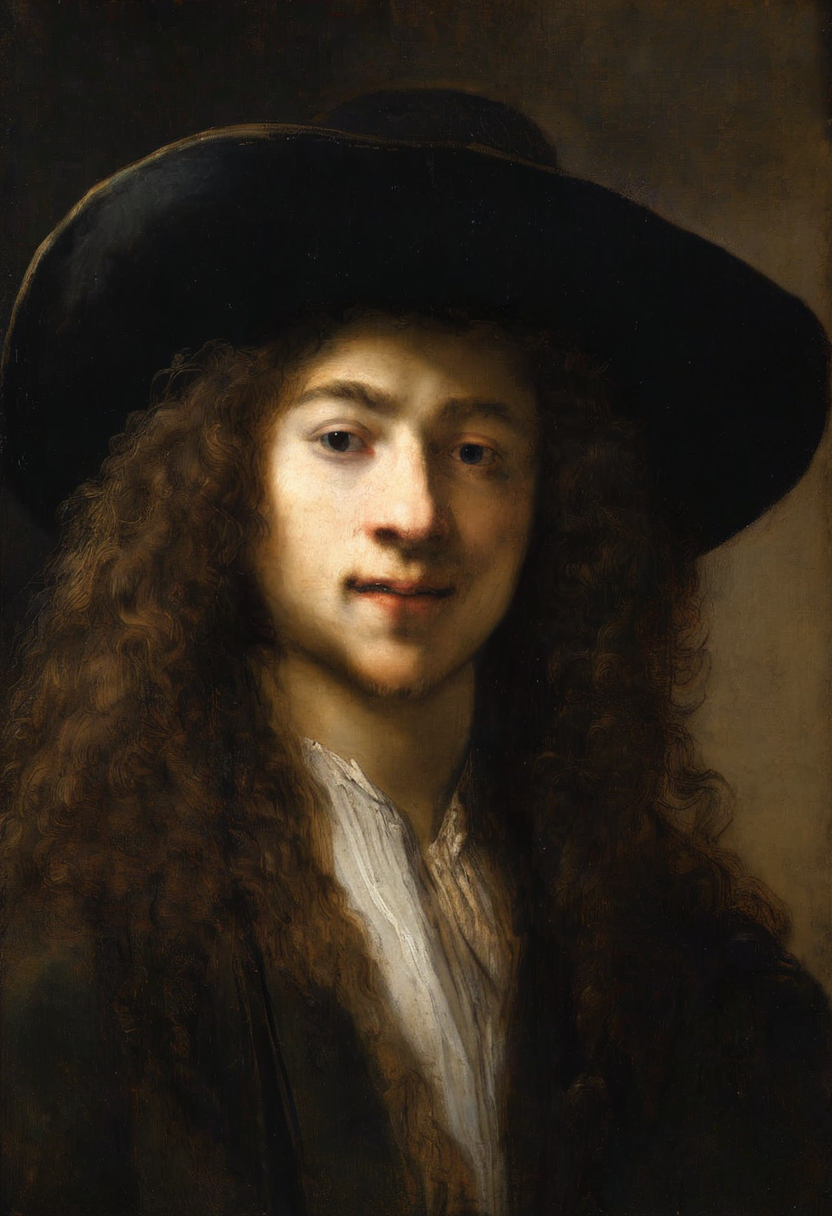

In [9]:
pipe_orig("""
Rembrandt (1606-1669), Dutch Golden Age - This captivating oil on canvas portrays a young man with long curly hair and an expressive face, His attire consists of a wide-brimmed hat and a dark coat, adding to the dramatic effect, The artwork is executed in Rembrandts cha
racteristic
""", num_inference_steps=25, guidance_scale=4.0, width=832, height=1216).images[0]

In [10]:
activation_stats.print_stats()


Linear Statistics:
  Forward Pass 1:
    min: -1.8307
    max: 3.7768
    mean: -0.0247
    std: 0.6444
  Forward Pass 2:
    min: -3.0848
    max: 7.4722
    mean: 0.0202
    std: 0.6694
  Forward Pass 3:
    min: -16.0865
    max: 4.1454
    mean: -4.3272
    std: 4.1955
  Forward Pass 4:
    min: -2.6807
    max: 0.8131
    mean: -0.0018
    std: 0.2819
  Forward Pass 5:
    min: -23.6804
    max: 4.1566
    mean: -0.1716
    std: 3.2583
  Forward Pass 6:
    min: -12.6316
    max: 2.7698
    mean: 0.2572
    std: 2.0423
  Forward Pass 7:
    min: -27.8490
    max: 4.5148
    mean: -0.1343
    std: 2.2314
  Forward Pass 8:
    min: -3.4218
    max: 8.1229
    mean: 0.0088
    std: 0.4813
  Forward Pass 9:
    min: -5.8868
    max: 6.1488
    mean: 0.0328
    std: 1.1313
  Forward Pass 10:
    min: -5.5312
    max: 6.4675
    mean: 0.0135
    std: 1.1446
  Forward Pass 11:
    min: -4.7371
    max: 4.8999
    mean: -0.0209
    std: 0.7815
  Forward Pass 12:
    min: -1.1032
    max:


  Forward Pass 16617:
    min: -7.3976
    max: 6.7504
    mean: 0.0126
    std: 1.2622
  Forward Pass 16618:
    min: -8.0471
    max: 7.9550
    mean: 0.0145
    std: 1.3948
  Forward Pass 16619:
    min: -5.6617
    max: 6.2563
    mean: -0.0068
    std: 1.0543
  Forward Pass 16620:
    min: -7.0054
    max: 5.2648
    mean: 0.0467
    std: 0.7653
  Forward Pass 16621:
    min: -3.2710
    max: 3.8866
    mean: -0.0084
    std: 0.7240
  Forward Pass 16622:
    min: -73.7193
    max: 85.4436
    mean: -0.0027
    std: 2.1381
  Forward Pass 16623:
    min: -23.5877
    max: 20.4343
    mean: -0.0024
    std: 0.8311
  Forward Pass 16624:
    min: -0.3348
    max: 0.3413
    mean: -0.0019
    std: 0.0566
  Forward Pass 16625:
    min: -5.8955
    max: 4.9501
    mean: -0.0938
    std: 0.6644
  Forward Pass 16626:
    min: -4.5718
    max: 5.1418
    mean: -0.0049
    std: 0.6145
  Forward Pass 16627:
    min: -6.8878
    max: 7.2048
    mean: -0.0165
    std: 1.2501
  Forward Pass 1662

: 

In [17]:
import torch
import torch.nn as nn
import numpy as np

def calculate_weight_norms(model):
    for name, module in model.named_modules():
        if hasattr(module, 'weight'):
            weight = module.weight.data
            
            # Calculate norms
            l1_norm = torch.norm(weight, p=1)
            l2_norm = torch.norm(weight, p=2)
            inf_norm = torch.norm(weight, p=float('inf'))
            
            # Calculate statistics
            weight_flat = weight.flatten()
            min_val = torch.min(weight_flat)
            max_val = torch.max(weight_flat)
            mean_val = torch.mean(weight_flat)
            std_val = torch.std(weight_flat)
            
            print(f"Module: {name}")
            print(f"  L1 Norm: {l1_norm:.4f}")
            print(f"  L2 Norm: {l2_norm:.4f}")
            print(f"  Inf Norm: {inf_norm:.4f}")
            print(f"  Min: {min_val:.4f}")
            print(f"  Max: {max_val:.4f}")
            print(f"  Mean: {mean_val:.4f}")
            print(f"  Std: {std_val:.4f}")
            print()



# Calculate and print weight norms and statistics
calculate_weight_norms(pipe.unet)

Module: conv_in
  L1 Norm: 724.0000
  L2 Norm: 8.6016
  Inf Norm: 0.4802
  Min: -0.4802
  Max: 0.3469
  Mean: -0.0007
  Std: 0.0801

Module: time_embedding.linear_1
  L1 Norm: 6564.0000
  L2 Norm: 13.6016
  Inf Norm: 0.1709
  Min: -0.1709
  Max: 0.1254
  Mean: -0.0009
  Std: 0.0212

Module: time_embedding.linear_2
  L1 Norm: 10984.0000
  L2 Norm: 11.2266
  Inf Norm: 0.1299
  Min: -0.1299
  Max: 0.1299
  Mean: 0.0001
  Std: 0.0088

Module: add_embedding.linear_1
  L1 Norm: 46336.0000
  L2 Norm: 41.0938
  Inf Norm: 1.3945
  Min: -1.0859
  Max: 1.3945
  Mean: -0.0021
  Std: 0.0215

Module: add_embedding.linear_2
  L1 Norm: 18688.0000
  L2 Norm: 20.3906
  Inf Norm: 0.4841
  Min: -0.4841
  Max: 0.2991
  Mean: -0.0001
  Std: 0.0159

Module: down_blocks.0.resnets.0.norm1
  L1 Norm: 222.0000
  L2 Norm: 12.4688
  Inf Norm: 0.9482
  Min: 0.4417
  Max: 0.9482
  Mean: 0.6938
  Std: 0.0671

Module: down_blocks.0.resnets.0.conv1
  L1 Norm: 18800.0000
  L2 Norm: 25.9844
  Inf Norm: 0.5757
  Min: -0.5

In [9]:
pipe_orig.unet.dtype

torch.bfloat16

In [11]:
import os
os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu:/usr/local/cuda/lib64:/opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/opt/aws-ofi-nccl/lib:$LD_LIBRARY_PATH"

In [18]:
pipe_orig.save_pretrained(save_directory="/home/ubuntu/efs_gpu/checkpoints/oils_v2_full/oils_v2_full_30_cool_5000_fixed")

In [4]:
from library.sdxl_original_unet import SdxlUNet2DConditionModel
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
import torch

In [5]:
model = SdxlUNet2DConditionModel()

In [12]:
model.load_state_dict(torch.load("/home/ubuntu/efs_gpu/checkpoints/oils_v2_full/oils_v2_full_30_cool_3000/pytorch_model_fsdp.bin"))

/tmp/ipykernel_138328/3835561409.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/ubuntu/efs_gpu/checkpoints/oils_v2_full/oils_v2_

<All keys matched successfully>

In [13]:
model.to('cuda').to(torch.float16)

SdxlUNet2DConditionModel(
  (time_embed): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (label_emb): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2816, out_features=1280, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1280, out_features=1280, bias=True)
    )
  )
  (input_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(

In [5]:
pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

ValueError: SdxlUNet2DConditionModel(
  (time_embed): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (label_emb): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2816, out_features=1280, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1280, out_features=1280, bias=True)
    )
  )
  (input_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Identity()
      )
    )
    (3): Sequential(
      (0): Downsample2D(
        (op): Conv2d(320, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (4): ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(320, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=640, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 640, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Conv2d(320, 640, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Transformer2DModel(
        (norm): GroupNorm(32, 640, eps=1e-06, affine=True)
        (proj_in): Linear(in_features=640, out_features=640, bias=True)
        (transformer_blocks): ModuleList(
          (0-1): 2 x BasicTransformerBlock(
            (attn1): CrossAttention(
              (to_q): Linear(in_features=640, out_features=640, bias=False)
              (to_k): Linear(in_features=640, out_features=640, bias=False)
              (to_v): Linear(in_features=640, out_features=640, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=640, out_features=640, bias=True)
              )
            )
            (ff): FeedForward(
              (net): ModuleList(
                (0): GEGLU(
                  (proj): Linear(in_features=640, out_features=5120, bias=True)
                )
                (1): Identity()
                (2): Linear(in_features=2560, out_features=640, bias=True)
              )
            )
            (attn2): CrossAttention(
              (to_q): Linear(in_features=640, out_features=640, bias=False)
              (to_k): Linear(in_features=2048, out_features=640, bias=False)
              (to_v): Linear(in_features=2048, out_features=640, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=640, out_features=640, bias=True)
              )
            )
            (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
          )
        )
        (proj_out): Linear(in_features=640, out_features=640, bias=True)
      )
    )
    (5): ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 640, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=640, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 640, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Identity()
      )
      (1): Transformer2DModel(
        (norm): GroupNorm(32, 640, eps=1e-06, affine=True)
        (proj_in): Linear(in_features=640, out_features=640, bias=True)
        (transformer_blocks): ModuleList(
          (0-1): 2 x BasicTransformerBlock(
            (attn1): CrossAttention(
              (to_q): Linear(in_features=640, out_features=640, bias=False)
              (to_k): Linear(in_features=640, out_features=640, bias=False)
              (to_v): Linear(in_features=640, out_features=640, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=640, out_features=640, bias=True)
              )
            )
            (ff): FeedForward(
              (net): ModuleList(
                (0): GEGLU(
                  (proj): Linear(in_features=640, out_features=5120, bias=True)
                )
                (1): Identity()
                (2): Linear(in_features=2560, out_features=640, bias=True)
              )
            )
            (attn2): CrossAttention(
              (to_q): Linear(in_features=640, out_features=640, bias=False)
              (to_k): Linear(in_features=2048, out_features=640, bias=False)
              (to_v): Linear(in_features=2048, out_features=640, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=640, out_features=640, bias=True)
              )
            )
            (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
          )
        )
        (proj_out): Linear(in_features=640, out_features=640, bias=True)
      )
    )
    (6): Sequential(
      (0): Downsample2D(
        (op): Conv2d(640, 640, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (7): ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 640, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(640, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 1280, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Conv2d(640, 1280, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Transformer2DModel(
        (norm): GroupNorm(32, 1280, eps=1e-06, affine=True)
        (proj_in): Linear(in_features=1280, out_features=1280, bias=True)
        (transformer_blocks): ModuleList(
          (0-9): 10 x BasicTransformerBlock(
            (attn1): CrossAttention(
              (to_q): Linear(in_features=1280, out_features=1280, bias=False)
              (to_k): Linear(in_features=1280, out_features=1280, bias=False)
              (to_v): Linear(in_features=1280, out_features=1280, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=1280, out_features=1280, bias=True)
              )
            )
            (ff): FeedForward(
              (net): ModuleList(
                (0): GEGLU(
                  (proj): Linear(in_features=1280, out_features=10240, bias=True)
                )
                (1): Identity()
                (2): Linear(in_features=5120, out_features=1280, bias=True)
              )
            )
            (attn2): CrossAttention(
              (to_q): Linear(in_features=1280, out_features=1280, bias=False)
              (to_k): Linear(in_features=2048, out_features=1280, bias=False)
              (to_v): Linear(in_features=2048, out_features=1280, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=1280, out_features=1280, bias=True)
              )
            )
            (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          )
        )
        (proj_out): Linear(in_features=1280, out_features=1280, bias=True)
      )
    )
    (8): ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 1280, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 1280, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Identity()
      )
      (1): Transformer2DModel(
        (norm): GroupNorm(32, 1280, eps=1e-06, affine=True)
        (proj_in): Linear(in_features=1280, out_features=1280, bias=True)
        (transformer_blocks): ModuleList(
          (0-9): 10 x BasicTransformerBlock(
            (attn1): CrossAttention(
              (to_q): Linear(in_features=1280, out_features=1280, bias=False)
              (to_k): Linear(in_features=1280, out_features=1280, bias=False)
              (to_v): Linear(in_features=1280, out_features=1280, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=1280, out_features=1280, bias=True)
              )
            )
            (ff): FeedForward(
              (net): ModuleList(
                (0): GEGLU(
                  (proj): Linear(in_features=1280, out_features=10240, bias=True)
                )
                (1): Identity()
                (2): Linear(in_features=5120, out_features=1280, bias=True)
              )
            )
            (attn2): CrossAttention(
              (to_q): Linear(in_features=1280, out_features=1280, bias=False)
              (to_k): Linear(in_features=2048, out_features=1280, bias=False)
              (to_v): Linear(in_features=2048, out_features=1280, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=1280, out_features=1280, bias=True)
              )
            )
            (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          )
        )
        (proj_out): Linear(in_features=1280, out_features=1280, bias=True)
      )
    )
  )
  (middle_block): ModuleList(
    (0): ResnetBlock2D(
      (in_layers): Sequential(
        (0): GroupNorm32(32, 1280, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (emb_layers): Sequential(
        (0): SiLU()
        (1): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (out_layers): Sequential(
        (0): GroupNorm32(32, 1280, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Identity()
        (3): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (skip_connection): Identity()
    )
    (1): Transformer2DModel(
      (norm): GroupNorm(32, 1280, eps=1e-06, affine=True)
      (proj_in): Linear(in_features=1280, out_features=1280, bias=True)
      (transformer_blocks): ModuleList(
        (0-9): 10 x BasicTransformerBlock(
          (attn1): CrossAttention(
            (to_q): Linear(in_features=1280, out_features=1280, bias=False)
            (to_k): Linear(in_features=1280, out_features=1280, bias=False)
            (to_v): Linear(in_features=1280, out_features=1280, bias=False)
            (to_out): ModuleList(
              (0): Linear(in_features=1280, out_features=1280, bias=True)
            )
          )
          (ff): FeedForward(
            (net): ModuleList(
              (0): GEGLU(
                (proj): Linear(in_features=1280, out_features=10240, bias=True)
              )
              (1): Identity()
              (2): Linear(in_features=5120, out_features=1280, bias=True)
            )
          )
          (attn2): CrossAttention(
            (to_q): Linear(in_features=1280, out_features=1280, bias=False)
            (to_k): Linear(in_features=2048, out_features=1280, bias=False)
            (to_v): Linear(in_features=2048, out_features=1280, bias=False)
            (to_out): ModuleList(
              (0): Linear(in_features=1280, out_features=1280, bias=True)
            )
          )
          (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        )
      )
      (proj_out): Linear(in_features=1280, out_features=1280, bias=True)
    )
    (2): ResnetBlock2D(
      (in_layers): Sequential(
        (0): GroupNorm32(32, 1280, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (emb_layers): Sequential(
        (0): SiLU()
        (1): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (out_layers): Sequential(
        (0): GroupNorm32(32, 1280, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Identity()
        (3): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (skip_connection): Identity()
    )
  )
  (output_blocks): ModuleList(
    (0-1): 2 x ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 2560, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(2560, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 1280, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Conv2d(2560, 1280, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Transformer2DModel(
        (norm): GroupNorm(32, 1280, eps=1e-06, affine=True)
        (proj_in): Linear(in_features=1280, out_features=1280, bias=True)
        (transformer_blocks): ModuleList(
          (0-9): 10 x BasicTransformerBlock(
            (attn1): CrossAttention(
              (to_q): Linear(in_features=1280, out_features=1280, bias=False)
              (to_k): Linear(in_features=1280, out_features=1280, bias=False)
              (to_v): Linear(in_features=1280, out_features=1280, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=1280, out_features=1280, bias=True)
              )
            )
            (ff): FeedForward(
              (net): ModuleList(
                (0): GEGLU(
                  (proj): Linear(in_features=1280, out_features=10240, bias=True)
                )
                (1): Identity()
                (2): Linear(in_features=5120, out_features=1280, bias=True)
              )
            )
            (attn2): CrossAttention(
              (to_q): Linear(in_features=1280, out_features=1280, bias=False)
              (to_k): Linear(in_features=2048, out_features=1280, bias=False)
              (to_v): Linear(in_features=2048, out_features=1280, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=1280, out_features=1280, bias=True)
              )
            )
            (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          )
        )
        (proj_out): Linear(in_features=1280, out_features=1280, bias=True)
      )
    )
    (2): ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 1920, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(1920, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 1280, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Conv2d(1920, 1280, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Transformer2DModel(
        (norm): GroupNorm(32, 1280, eps=1e-06, affine=True)
        (proj_in): Linear(in_features=1280, out_features=1280, bias=True)
        (transformer_blocks): ModuleList(
          (0-9): 10 x BasicTransformerBlock(
            (attn1): CrossAttention(
              (to_q): Linear(in_features=1280, out_features=1280, bias=False)
              (to_k): Linear(in_features=1280, out_features=1280, bias=False)
              (to_v): Linear(in_features=1280, out_features=1280, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=1280, out_features=1280, bias=True)
              )
            )
            (ff): FeedForward(
              (net): ModuleList(
                (0): GEGLU(
                  (proj): Linear(in_features=1280, out_features=10240, bias=True)
                )
                (1): Identity()
                (2): Linear(in_features=5120, out_features=1280, bias=True)
              )
            )
            (attn2): CrossAttention(
              (to_q): Linear(in_features=1280, out_features=1280, bias=False)
              (to_k): Linear(in_features=2048, out_features=1280, bias=False)
              (to_v): Linear(in_features=2048, out_features=1280, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=1280, out_features=1280, bias=True)
              )
            )
            (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          )
        )
        (proj_out): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (2): Upsample2D(
        (conv): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 1920, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(1920, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=640, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 640, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Conv2d(1920, 640, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Transformer2DModel(
        (norm): GroupNorm(32, 640, eps=1e-06, affine=True)
        (proj_in): Linear(in_features=640, out_features=640, bias=True)
        (transformer_blocks): ModuleList(
          (0-1): 2 x BasicTransformerBlock(
            (attn1): CrossAttention(
              (to_q): Linear(in_features=640, out_features=640, bias=False)
              (to_k): Linear(in_features=640, out_features=640, bias=False)
              (to_v): Linear(in_features=640, out_features=640, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=640, out_features=640, bias=True)
              )
            )
            (ff): FeedForward(
              (net): ModuleList(
                (0): GEGLU(
                  (proj): Linear(in_features=640, out_features=5120, bias=True)
                )
                (1): Identity()
                (2): Linear(in_features=2560, out_features=640, bias=True)
              )
            )
            (attn2): CrossAttention(
              (to_q): Linear(in_features=640, out_features=640, bias=False)
              (to_k): Linear(in_features=2048, out_features=640, bias=False)
              (to_v): Linear(in_features=2048, out_features=640, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=640, out_features=640, bias=True)
              )
            )
            (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
          )
        )
        (proj_out): Linear(in_features=640, out_features=640, bias=True)
      )
    )
    (4): ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 1280, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(1280, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=640, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 640, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Conv2d(1280, 640, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Transformer2DModel(
        (norm): GroupNorm(32, 640, eps=1e-06, affine=True)
        (proj_in): Linear(in_features=640, out_features=640, bias=True)
        (transformer_blocks): ModuleList(
          (0-1): 2 x BasicTransformerBlock(
            (attn1): CrossAttention(
              (to_q): Linear(in_features=640, out_features=640, bias=False)
              (to_k): Linear(in_features=640, out_features=640, bias=False)
              (to_v): Linear(in_features=640, out_features=640, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=640, out_features=640, bias=True)
              )
            )
            (ff): FeedForward(
              (net): ModuleList(
                (0): GEGLU(
                  (proj): Linear(in_features=640, out_features=5120, bias=True)
                )
                (1): Identity()
                (2): Linear(in_features=2560, out_features=640, bias=True)
              )
            )
            (attn2): CrossAttention(
              (to_q): Linear(in_features=640, out_features=640, bias=False)
              (to_k): Linear(in_features=2048, out_features=640, bias=False)
              (to_v): Linear(in_features=2048, out_features=640, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=640, out_features=640, bias=True)
              )
            )
            (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
          )
        )
        (proj_out): Linear(in_features=640, out_features=640, bias=True)
      )
    )
    (5): ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 960, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(960, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=640, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 640, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Conv2d(960, 640, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Transformer2DModel(
        (norm): GroupNorm(32, 640, eps=1e-06, affine=True)
        (proj_in): Linear(in_features=640, out_features=640, bias=True)
        (transformer_blocks): ModuleList(
          (0-1): 2 x BasicTransformerBlock(
            (attn1): CrossAttention(
              (to_q): Linear(in_features=640, out_features=640, bias=False)
              (to_k): Linear(in_features=640, out_features=640, bias=False)
              (to_v): Linear(in_features=640, out_features=640, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=640, out_features=640, bias=True)
              )
            )
            (ff): FeedForward(
              (net): ModuleList(
                (0): GEGLU(
                  (proj): Linear(in_features=640, out_features=5120, bias=True)
                )
                (1): Identity()
                (2): Linear(in_features=2560, out_features=640, bias=True)
              )
            )
            (attn2): CrossAttention(
              (to_q): Linear(in_features=640, out_features=640, bias=False)
              (to_k): Linear(in_features=2048, out_features=640, bias=False)
              (to_v): Linear(in_features=2048, out_features=640, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=640, out_features=640, bias=True)
              )
            )
            (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
          )
        )
        (proj_out): Linear(in_features=640, out_features=640, bias=True)
      )
      (2): Upsample2D(
        (conv): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (6): ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 960, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(960, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Conv2d(960, 320, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (7-8): 2 x ModuleList(
      (0): ResnetBlock2D(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 640, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(640, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Conv2d(640, 320, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  )
  (out): ModuleList(
    (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
    (1): SiLU()
    (2): Conv2d(320, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
) is of type: <class 'library.sdxl_original_unet.SdxlUNet2DConditionModel'>, but should be <class 'diffusers.models.modeling_utils.ModelMixin'>